# Monte Carlo Calibration via Deep Learning

## Sample code for calibrating a rough Bergomi model to SPX options data

This code contains a sample implementation for the *Automatic Monte Carlo Calibration (AMCC)* method introduced in the paper *Monte Carlo Calibration via Deep Learning*.

### Getting started and loading the data

In [1]:
!pip install py_vollib_vectorized
!pip install mpmath
import pandas as pd
import datetime
import numpy as np
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
import py_vollib_vectorized
import warnings
import torch
from torch.distributions import Normal
warnings.filterwarnings("ignore")
np.random.seed(1)
from mpmath import hyp2f1

First we need to load the relevant data. In the paper we use Data from OptionMetrics via Wharton Research Data Services (WRDS).

The data file needs to contain a list of contracts with the following attributes:

- **date**  (e.g. '2013-08-17')
- **exdate** (maturity of the contract in the same format)
- **cp_flag** ('p' for put, 'c' for call)
- **strike**
- **best_bid** (best bid price)
- **best_offer** (best ask price)
- **volume**
- **forward_price** (SPX forward)
- **midP** (mid price of contract)
- **maturity** (time-to-maturity as float)
- **Spot** 	(SPX spot)
- **bid_vols** (implied volatility for best bid price)
- **offer_vols** (implied volatility for best ask price)
- **mid_vols** (implied volatility for mid price)

In [2]:
## When running on colab, upload of data works best by activating this celL:
if False:
    from google.colab import files

    uploaded = files.upload()

    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))

In [3]:
## Once uploaded, we load the data into a pandas dataframe.

data_full = pd.read_csv('IV_data2013.csv')
data_full = data_full.dropna()

In [4]:
dates = data_full.drop_duplicates('date')['date'].tolist()
print(dates)
## Select the relevant dates here
dates = dates[0:25]
data_full.allDates = dates
data_full.count()[0]

['2013-08-14', '2013-08-15']


1310

In [5]:
## Only use part of the data for training: specify volume threshold here.
threshold =  1000
data = data_full[data_full['volume']>threshold]
data=data.dropna()
data.allDates = dates

In [6]:
data.count()[0]/data_full.count()[0]

0.19083969465648856

In [7]:
data

,secid,date,exdate,last_date,cp_flag,strike,best_bid,best_offer,volume,impl_volatility,forward_price,div_convention,midP,maturity,Spot,Fwd,discountFactor,bid_vols,offer_vols,mid_vols
0,108105,2013-08-14,2013-08-17,20130814.0,c,1690.0,2.60,2.95,8669,0.135092,1685.299231,I,2.775,0.008214,1685.390015,0.0,0.0,0.074887,0.081084,0.077995
1,108105,2013-08-14,2013-08-17,20130814.0,c,1695.0,1.20,1.55,6704,0.133820,1685.299231,I,1.375,0.008214,1685.390015,0.0,0.0,0.073181,0.081201,0.077261
2,108105,2013-08-14,2013-08-17,20130814.0,c,1700.0,0.50,0.85,18903,0.137558,1685.299231,I,0.675,0.008214,1685.390015,0.0,0.0,0.073124,0.085055,0.079419
3,108105,2013-08-14,2013-08-17,20130814.0,c,1705.0,0.20,0.35,4316,0.137626,1685.299231,I,0.275,0.008214,1685.390015,0.0,0.0,0.074569,0.083666,0.079458
4,108105,2013-08-14,2013-08-17,20130814.0,c,1710.0,0.15,0.20,5199,0.151357,1685.299231,I,0.175,0.008214,1685.390015,0.0,0.0,0.085085,0.089498,0.087386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,108105,2013-08-15,2013-09-06,20130815.0,p,1625.0,11.10,11.40,1094,0.153784,1659.379011,I,11.250,0.060234,1661.319946,0.0,0.0,0.152686,0.154861,0.153775
1277,108105,2013-08-15,2013-09-06,20130815.0,p,1635.0,13.40,13.60,2692,0.147068,1659.379011,I,13.500,0.060234,1661.319946,0.0,0.0,0.146383,0.147732,0.147058
1278,108105,2013-08-15,2013-09-06,20130815.0,p,1640.0,14.60,15.00,2183,0.143691,1659.379011,I,14.800,0.060234,1661.319946,0.0,0.0,0.142371,0.144989,0.143681
1280,108105,2013-08-15,2013-09-06,20130815.0,p,1650.0,17.70,18.10,2063,0.137469,1659.379011,I,17.900,0.060234,1661.319946,0.0,0.0,0.136205,0.138709,0.137457


### Defining auxiliary functions

In [8]:
def covariance_matrix(H,M,T):
    """ Computes the covariance matrix for the exact rough Bergomi simluation scheme.

    Args:
        H: Hurst parameter (float)
        M: number of time steps (int)
        T: maturity (float)
    Returns:
        np.ndarray: covariance matrix Shape (2M,2M)
    """

    h = T/M
    mat = np.zeros((2*M,2*M))
    gamma_aux = 0.5 - H
    frac_aux = 1.0/(1.0-gamma_aux)

    for i in range(M):
        for j in range(M):

            mm = min(i,j) +1
            mm_x = max(i,j) +1

            mat[2*i,2*j+1] = (  ((i+1)*h)**(H+0.5) - ( (i+1)*h  - mm*h )**(H+0.5) )/(H+0.5)

            mat[2*i,2*j] = ((mm*h)**(2*H))*hyp2f1(1.0, gamma_aux, 2-gamma_aux,mm/mm_x)*frac_aux*(mm/mm_x)**gamma_aux

            mat[2*i+1,2*j+1] = (mm*h)

            mat[2*i+1,2*j] = (  ((j+1)*h)**(H+0.5) - ( (j+1)*h  - mm*h )**(H+0.5) )/(H+0.5)

    return mat


def kernel(time_points,hurst_exp):

    kernels = time_points**(hurst_exp-0.5)

    return kernels


Next we build two dictionaries that will be useful when accessing the data.

In [9]:
df = data_full[data_full['date']==dates[0]]
exdates = df.drop_duplicates('exdate')['exdate'].tolist()
print(exdates)

dfDict = {}
for t in data_full.allDates:
    dfT = data_full.loc[data_full['date'] == t]
    allMats = dfT.drop_duplicates('exdate')['exdate'].tolist()
    dfDict[t] = []
    for tau in allMats:
        dfTtau = dfT[dfT["exdate"] == tau]
        dfDict[t].append((dfTtau, tau))
data_full.dfDict=dfDict

['2013-08-17', '2013-09-21', '2013-10-19', '2013-11-16', '2013-12-21', '2014-01-18', '2014-03-22', '2014-06-21', '2014-12-20', '2015-01-17', '2015-12-19', '2013-09-30', '2013-12-31', '2013-08-23', '2013-08-30', '2013-09-06', '2013-09-13']


In [10]:
df = data[data['date']==dates[0]]
exdates = df.drop_duplicates('exdate')['exdate'].tolist()
print(exdates)

for exdate in exdates:
    df_tau = df[df['exdate']==exdate]

dfDict = {}
for t in data.allDates:
    dfT = data.loc[data['date'] == t]
    allMats = dfT.drop_duplicates('exdate')['exdate'].tolist()
    dfDict[t] = []
    for tau in allMats:
        dfTtau = dfT[dfT["exdate"] == tau]
        dfDict[t].append((dfTtau, tau))
data.dfDict=dfDict

['2013-08-17', '2013-09-21', '2013-10-19', '2013-11-16', '2013-12-21', '2014-03-22', '2014-06-21', '2014-12-20', '2013-09-30', '2013-08-23', '2013-08-30', '2013-09-06', '2013-09-13']


Check how many datapoints you are using approximately per day.

In [11]:
counter = 0.
for i in range(len(dates)):
    counter = counter + data[data['date'] == dates[i]].count()[0]
print(counter / len(dates))

125.0


Define the neural network that could be used as forward variance curve parametrization.

In [47]:
hidden_size=10
class FNN_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(1, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, 1),
            torch.nn.Softplus()
        )
    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out
FNN = FNN_model()

### Calibration

Here we define the object used for calibration.

In [48]:
class Rough_Bergomi_calibration():

    def __init__(self,select_date_ind=0):
        self.v0 =  torch.tensor(0.02)
        self.eta =  torch.tensor(2.3)
        self.iter_numb = 1
        self.learning_rate = 0.01
        self.errorMessage = False
        self.batch_size = torch.tensor(25000)
        self.time_steps = 50
        self.time_steps_t = torch.tensor(self.time_steps)
        self.r0=torch.tensor(0.0)
        self.xi=torch.ones(30)
        self.hurst = torch.tensor(0.05)
        self.rho = torch.tensor(-0.9)
        self.sqrt_rho = torch.sqrt(1-self.rho**2)
        self.use_NN_fwc = True
        self.use_exact_sim = True
        self.eval_exact = True
        self.select_date_ind = select_date_ind
        if self.use_exact_sim:
            self.build_cholesky(self.select_date_ind)


    def select_data(self, data, select_date_ind, select_mat_ind):
        '''
        Load data for date specified by index and maturity specified by index and set
        object parameters (time-grid, maturity,...) accordingly.
        '''
        if (select_date_ind >= 0) & (select_date_ind < len(data.allDates)):

            self.o = data.allDates[select_date_ind] ## Select one particular day

            if (select_mat_ind >= 0) & (select_mat_ind < len(data.dfDict[self.o])):

                df_extract = data.dfDict[self.o][select_mat_ind]
            else:
                self.errorMessage = True
        else:
            self.errorMessage = True

        if self.errorMessage:
            print("No data available. Please choose other")

        else:
            self.Tau = df_extract[1]
            df = df_extract[0]

            self.data = df
            self.forward = torch.tensor(np.array(self.data["forward_price"])[0])
            self.strikes = torch.tensor(np.array(self.data["strike"]))
            self.ivs_market = torch.tensor(np.array(self.data["mid_vols"]))
            self.ivs_bid = torch.tensor(np.array(self.data["bid_vols"]))
            self.ivs_offer = torch.tensor(np.array(self.data["offer_vols"]))
            self.mids = self.data["midP"]
            self.bids = self.data['best_bid']
            self.offers = self.data['best_offer']
            self.spot = torch.tensor(np.array(self.data['Spot'])[0])
            self.maturity = torch.tensor(np.array(self.data["maturity"].iloc[0]))
            self.h = torch.tensor(self.maturity/self.time_steps).float()
            self.pc_factor = torch.tensor(np.array(2.*(df_extract[0]["cp_flag"] == "c")-1.))
            self.logStrikes = -np.log(df["forward_price"] / df["strike"])
            if self.use_NN_fwc:
                self.variance_curve = self.forward_variance_curve_nn()
            else:
                self.variance_curve = self.forward_variance_curve()
            self.cp_flag = df_extract[0]["cp_flag"]
            self.cholesky_mat = self.chol_list[select_mat_ind]

    def build_cholesky(self,select_date_ind):
        '''
        Compute Cholesky decomposition of covariance matrix for all maturities for a given date.
        '''
        self.chol_list = []
        for i in range(len(dfDict[data.allDates[select_date_ind]])):
            o = data.allDates[select_date_ind]
            df_extract = data.dfDict[o][i]
            maturity = torch.tensor(np.array(df_extract[0]["maturity"].iloc[0]))
            cholesky_mat_tmp = covariance_matrix(self.hurst.detach().numpy(),self.time_steps,maturity.detach().numpy())
            cholesky_mat = torch.tensor(np.linalg.cholesky(cholesky_mat_tmp)).to(torch.float32)
            self.chol_list.append(cholesky_mat)



    def forward_variance_curve(self):
        '''
        Evaluate piecewise linear forward variance curve at time points defined by current grid.
        '''
        variance_curve = torch.ones(self.time_steps)
        time_grid = self.h*torch.arange(1,self.time_steps+1)
        for k in range(10):
            indices = time_grid>k*0.0025
            indices[time_grid<=(k-1)*0.0025]=False
            variance_curve[indices] = torch.abs(self.xi[k])
        for k in range(1,10):
            indices = time_grid>k*0.025
            indices[time_grid<=(k-1)*0.025]=False
            variance_curve[indices] = torch.abs(self.xi[k+9])
        for k in range(1,10):
            indices = time_grid>k*0.25
            indices[time_grid<=(k-1)*0.25]=False
            variance_curve[indices] = torch.abs(self.xi[k+18])
        return variance_curve

    def forward_variance_curve_nn(self):
        '''
        Evaluate neural network forward variance curve at time points defined by current grid.
        '''

        variance_curve = torch.ones(self.time_steps)
        time_grid = (self.h*torch.arange(1,self.time_steps+1)).reshape(self.time_steps,1)
        variance_curve = FNN(time_grid)
        return variance_curve

    def payoff(self,samples):
        '''
        Evaluate put / call payoffs
        '''

        diff_tmp = samples.reshape(-1,1)-self.strikes
        diff_tmp = diff_tmp * self.pc_factor
        diff_tmp [diff_tmp  < 0] = 0

        return diff_tmp

    def simulated_paths_rough_bergomi(self,states_in,path_bm,path_bm_2):
        '''
        Generate sample paths of the rough Bergomi model using the approximate sampling scheme
        '''

        vec_dim = path_bm_2.shape
        time_steps = vec_dim[1]

        log_states = torch.log(states_in)
        vol_states = torch.ones(vec_dim[0])*self.v0


        for i in range(self.time_steps):

            vec_tmp = self.h*(i + 1 - torch.arange(0, i+1))
            kernels = kernel(vec_tmp,self.hurst)
            fbm = torch.matmul(path_bm[:,0:(i+1)],kernels)

            brownian_incr_v = path_bm[:,i]
            brownian_incr_s = self.rho*brownian_incr_v + self.sqrt_rho*path_bm_2[:,i]

            log_states  = log_states + (self.r0-0.5*vol_states)*self.h+torch.sqrt(vol_states)*brownian_incr_s
            vol_states =  self.v0*self.variance_curve[i]*torch.exp(self.eta*torch.sqrt(2*self.hurst)*fbm - ((i+1)*self.h)**(2*self.hurst)*(self.eta**2)/2)


        return torch.exp(log_states)




    def call_rough_bergomi_anti(self,num_samples):
        '''
        Compute option prices in the rough Bergomi model using the approximate sampling scheme
        '''

        init_states  = torch.ones(num_samples)*self.spot
        paths_bm_test = torch.normal(0, 1, (num_samples,self.time_steps_t))*torch.sqrt(self.h)
        paths_bm_test_2 = torch.normal(0, 1, (num_samples,self.time_steps_t))*torch.sqrt(self.h)

        samples_test= self.simulated_paths_rough_bergomi(init_states,paths_bm_test,paths_bm_test_2)
        samples_test_anti= self.simulated_paths_rough_bergomi(init_states,-paths_bm_test,-paths_bm_test_2)



        return (torch.mean(torch.transpose(self.payoff(samples_test),0,1),dim=1) + torch.mean(torch.transpose(self.payoff(samples_test_anti),0,1),dim=1))/2

    def simulated_paths_rough_bergomi_exact(self,states_in,path_bm,vec_normal):
        '''
        Generate sample paths of the rough Bergomi model using the exact sampling scheme
        '''

        vec_dim = path_bm.shape
        time_steps = vec_dim[1]

        log_states = torch.log(states_in)
        vol_states = torch.ones(vec_dim[0])*torch.abs(self.v0)
        #vec_normal is of size (2M,N)
        #cov_cholesky is lower diagonal of size (2M,2M)

        #columns contain, for each n \in [[1,N]], the correlated Gaussian RV
        prod_mat = torch.transpose(torch.mm(self.cholesky_mat, vec_normal),0,1)
        tmp = torch.zeros(1)

        for i in range(self.time_steps):
            fbm = prod_mat[:,2*i]
            brownian_incr_v = prod_mat[:,2*i+1] - prod_mat[:,(2*(i-1)+1)]*tmp
            brownian_incr_s = self.rho*brownian_incr_v + self.sqrt_rho*path_bm[:,i]
            log_states  = log_states + (self.r0-0.5*vol_states)*self.h+torch.sqrt(vol_states)*brownian_incr_s
            vol_states =  torch.abs(self.v0)*torch.abs(self.variance_curve[i])*torch.exp(self.eta*torch.sqrt(2*self.hurst)*fbm - ((i+1)*self.h)**(2*self.hurst)*(self.eta**2)/2)
            vol_states = torch.maximum(vol_states,torch.tensor(0.))
            tmp = 1


        return torch.exp(log_states)



    def call_rough_bergomi_exact(self,num_samples):
        '''
        Compute option prices in the rough Bergomi model using the exact sampling scheme

        '''
        init_states  = torch.ones(num_samples)*self.spot
        paths_bm_test = torch.normal(0, 1, (num_samples,self.time_steps_t))*torch.sqrt(self.h)
        vec_normal =  torch.normal(0, 1, (2*self.time_steps_t,num_samples))
        samples_test= self.simulated_paths_rough_bergomi_exact(init_states,paths_bm_test,vec_normal)


        return torch.mean(torch.transpose(self.payoff(samples_test),0,1),dim=1)



    def AMCC_optim(self,iter_numb,select_date_ind=0):
        '''
        Perform Monte Carlo Calibration using AMCC
        '''

        self.v0.requires_grad = True
        self.eta.requires_grad = True
        self.rho.requires_grad= True
        if self.use_exact_sim:
            self.hurst.requires_grad = False
            param_list = [self.v0,self.eta,self.rho]
        else:
            self.hurst.requires_grad = True
            param_list = [self.v0,self.eta,self.rho,self.hurst]

        if self.use_NN_fwc:
            param_list = list(FNN.parameters())+param_list
        else:
            self.xi.requires_grad = True
            param_list = param_list + [self.xi]

        optimizer = torch.optim.Adam(param_list, lr=self.learning_rate)
        FNN.train()
        for itr in range(iter_numb):
            loss = torch.tensor(0.)
            for i in range(len(dfDict[data.allDates[select_date_ind]])):
                self.select_data(data,select_date_ind,i)
                if self.use_exact_sim:
                    prices = self.call_rough_bergomi_exact(self.batch_size)
                else:
                    prices = self.call_rough_bergomi_anti(self.batch_size)
                market_data = torch.tensor(np.array(self.mids))
                difference = (torch.exp(-self.r0*self.maturity)*prices - market_data)
                loss =loss + torch.sum((difference)**2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if itr%3==0:
                print("Epoch number: {} and the loss : {}".format(itr,loss.item()))




    def AMCC_calibrate(self, plot_maturities = [0,1],print_options = [True, True]):
        '''
        Carry out AMCC and print results
        '''

        self.AMCC_optim(self.iter_numb,self.select_date_ind)
        if print_options[0]:
            print("Optimal parameters: ")
            print("v_0 = ", self.v0.detach().numpy().item(0))
            print("\eta = ", self.eta.detach().numpy().item(0))
            print("\rho = ", self.rho.detach().numpy().item(0))
            print("H = ", self.hurst.detach().numpy().item(0))
        if print_options[1]:
            for maturities_ind in plot_maturities:
                date = dates[self.select_date_ind]
                self.select_data(data,self.select_date_ind,maturities_ind)
                market_data = torch.tensor(np.array(self.ivs_market))
                if RB.eval_exact:
                    cholesky_mat_tmp = covariance_matrix(self.hurst.detach().numpy(),self.time_steps,self.maturity.detach().numpy())
                    self.cholesky_mat = torch.tensor(np.linalg.cholesky(cholesky_mat_tmp)).to(torch.float32)

                model_prices = self.evaluate(300000)

                iv_RB = py_vollib_vectorized.implied_volatility.vectorized_implied_volatility(model_prices.detach().numpy(),np.array(self.spot),np.array(self.strikes),np.array(self.maturity),np.array(self.r0),self.cp_flag)
                plt.figure(figsize=(6, 3))
                plt.plot(self.logStrikes, self.ivs_market, 'bo', fillstyle='none',label='Market')
                plt.plot(self.logStrikes, iv_RB, 'g+',label='RB')
                plottitle = "Date: " + str(date)
                plottitle+= " || maturity: " + str(self.Tau)
                plt.title(plottitle)
                plt.legend()
                plt.show()
                plt.figure(figsize=(6, 3))
                plt.plot(self.logStrikes, self.mids, 'bo', fillstyle='none',label='Market')
                plt.plot(self.logStrikes, model_prices.detach().numpy(), 'g+',label='RB')
                plottitle = "Date: " + str(date)
                plottitle+= " || maturity: " + str(self.Tau)
                plt.title(plottitle)
                plt.legend()
                plt.show()
                print(np.mean(np.array(iv_RB)-np.array(self.ivs_market))**2)

    def evaluate(self,test_num_samples,select_date_ind=0):
        FNN.eval()
        with torch.no_grad():
            if self.eval_exact:
                model_prices = torch.exp(-self.r0*self.maturity)*self.call_rough_bergomi_exact(test_num_samples)
            else:
                model_prices = torch.exp(-self.r0*self.maturity)*self.call_rough_bergomi_anti(test_num_samples)
        return model_prices










def evaluate_RMSE(data,model,show_plots=False):
    '''
       Evaluate model fit to data.
    '''
    select_date_ind = model.select_date_ind
    with torch.no_grad():
        loss = 0.
        count = 0.
        date = data.allDates[select_date_ind]
        hits_count = 0.
        mape = 0.
        delta_s = 0.
        price_metric = 0.
        model.chol_list = []
        for i in range(len(dfDict[date])):
            model.chol_list.append(0.)
            model.select_data(data,select_date_ind,i)
            cholesky_mat_tmp = covariance_matrix(model.hurst.detach().numpy(),model.time_steps,model.maturity.detach().numpy())
            model.cholesky_mat = torch.tensor(np.linalg.cholesky(cholesky_mat_tmp)).to(torch.float32)
            model_prices = (model.evaluate(100000)).detach().numpy()
            implied_vols = py_vollib_vectorized.implied_volatility.vectorized_implied_volatility(model_prices,np.array(model.forward),np.array(model.strikes),np.array(model.maturity),np.array(model.r0),model.cp_flag)
            market_data = np.array(model.ivs_market)
            market_prices = np.array(model.mids)
            loss =loss + np.sum((np.array(implied_vols) - market_data)**2)#,dim=1)
            mape = mape + np.sum(np.abs((np.array(implied_vols) - market_data))/(market_data))#,dim=1)
            count = count + market_data.shape[0]
            if show_plots:
                plt.figure(figsize=(6, 3))
                plt.plot(model.logStrikes, market_data, 'bo', fillstyle='none',label='Mid')
                plt.plot(model.logStrikes, np.array(model.ivs_bid), 'rx', fillstyle='none',label='Bid')
                plt.plot(model.logStrikes, np.array(model.ivs_offer), 'mx', fillstyle='none',label='Ask')
                plt.plot(model.logStrikes, implied_vols, 'g+',label='Rough Bergomi')
                plottitle = "Date: " + str(date)
                plottitle+= " || maturity: " + str(model.Tau)
                plt.title(plottitle)
                plt.legend()
                plt.xlabel('Log-moneyness')
                plt.ylabel('Implied Volatility')
                nameFile = "RoughBergomiSmiles_" +str(date)+ "_" + str(model.Tau)+".png" #str(pd.to_datetime(model.Tau)-pd.to_datetime(dates[0])) + ".png"
                #nameFile = "RoughBergomiSmiles_" +str(date)+ "_" + str(pd.to_datetime(model.Tau)-pd.to_datetime(dates[0])) + ".png"
                plt.savefig(nameFile,bbox_inches='tight')
                plt.show()
            hits = (np.array(model.ivs_bid)<np.array(implied_vols).T)*(np.array(model.ivs_offer)>np.array(implied_vols).T)
            print(np.sum(hits)/implied_vols.shape[0])
            hits_count = hits_count + np.sum(hits)
            price_metric = price_metric + np.sum(((model_prices-market_prices)/np.array(model.spot))<(1./100.))
            spread = np.array(model.offers)-np.array(model.bids)
            delta_s = delta_s + np.sum(2*np.abs(model_prices-np.array(model.mids))/spread)
            #print(np.sum(hits))
    print('Loss:',np.sqrt(loss/count)) ## Mean-squared implied volatility error
    print('MAPE:',mape/count) ## Mean absolute percentage error
    print('Hits:', hits_count/count) ## Hits
    print('Delta_spread:',delta_s/count) ## Error relative to spread
    print('Market metric:',price_metric/count)
    return((np.sqrt(loss/count))), hits_count/count, delta_s/count


In [49]:
## Initiate calibration
RB = Rough_Bergomi_calibration()
RB.use_NN_fwc = True
RB.iter_numb = 500
RB.learning_rate = 0.01

In [50]:
## To calibrate the Hurst parameter first, we may want to run this cell first:
if False:
    RB.use_exact_sim = False
    RB.eval_exact =False
    RB.AMCC_calibrate(print_options = [True, False])
    RB.build_cholesky(0)

Epoch number: 0 and the loss : 8188.914766769853
Epoch number: 3 and the loss : 2994.089172378838
Epoch number: 6 and the loss : 3739.0051507927865
Epoch number: 9 and the loss : 2142.505882618219
Epoch number: 12 and the loss : 2789.9133180552094
Epoch number: 15 and the loss : 2513.278993927829
Epoch number: 18 and the loss : 2074.0043052102938
Epoch number: 21 and the loss : 2216.3352067143114
Epoch number: 24 and the loss : 1959.627539410754
Epoch number: 27 and the loss : 1827.198276669413
Epoch number: 30 and the loss : 1843.5643419507544
Epoch number: 33 and the loss : 1735.2976038447143
Epoch number: 36 and the loss : 1726.699260127569
Epoch number: 39 and the loss : 1587.7720151565325
Epoch number: 42 and the loss : 1379.6447950378686
Epoch number: 45 and the loss : 1256.4119029260835
Epoch number: 48 and the loss : 1038.184631774447
Epoch number: 51 and the loss : 798.2537729748451
Epoch number: 54 and the loss : 724.2295815812397
Epoch number: 57 and the loss : 560.552012726

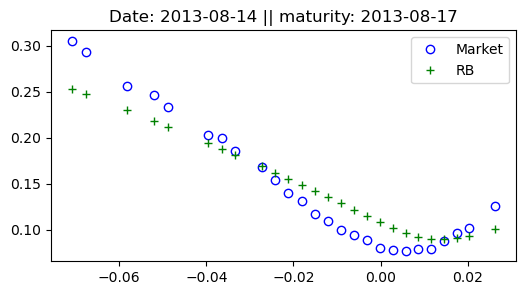

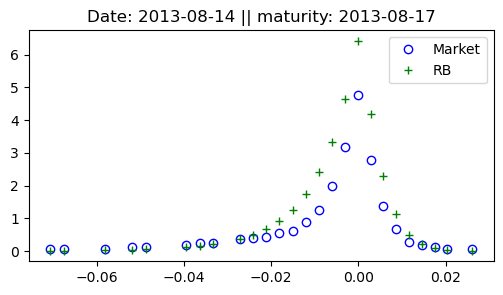

1.6765263502951656e-06


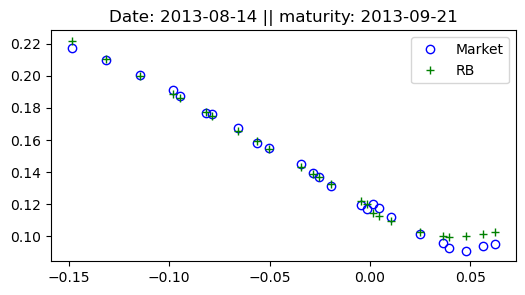

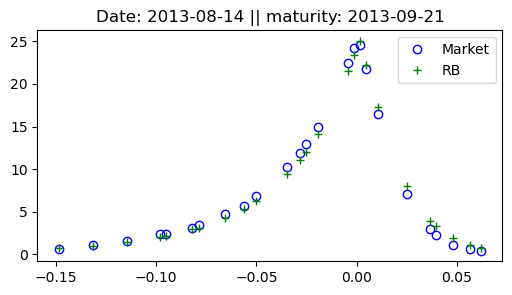

1.185347705518185e-06


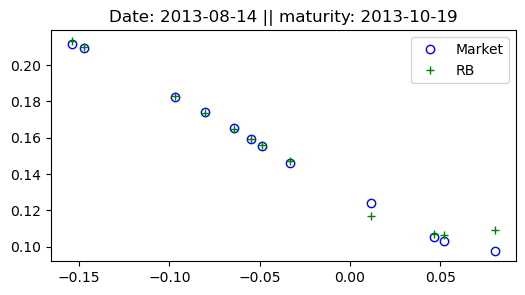

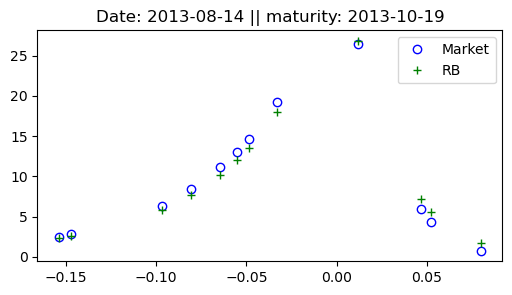

1.2518366948232575e-06


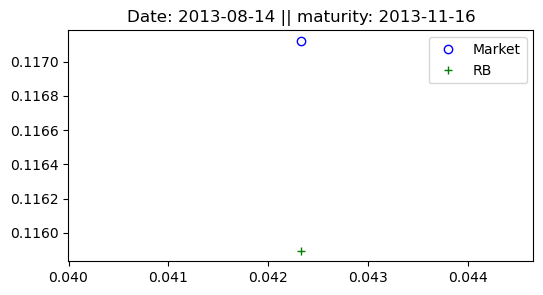

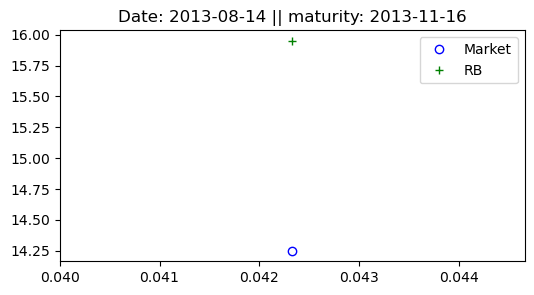

1.5050187053108886e-06


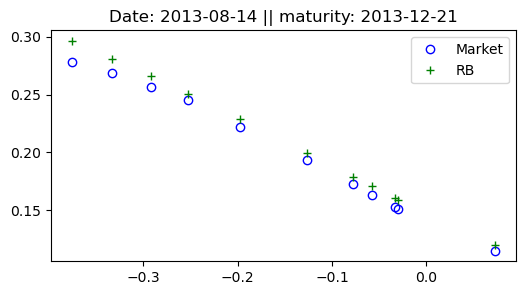

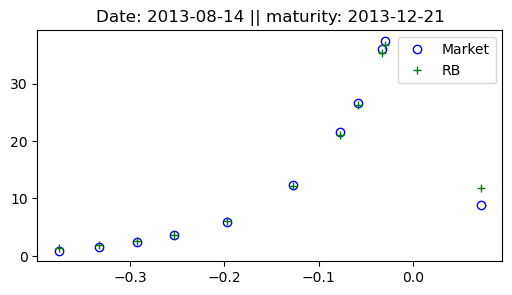

6.969310221142366e-05


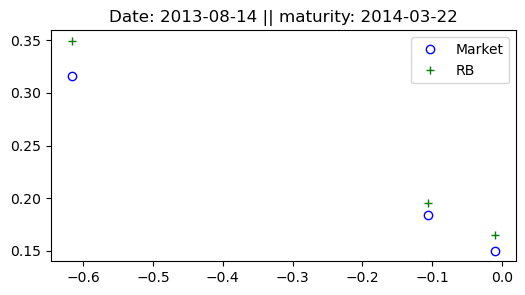

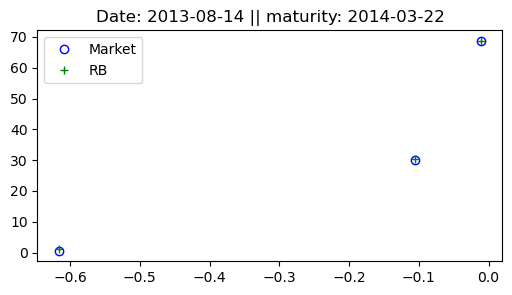

0.00039917428922191744


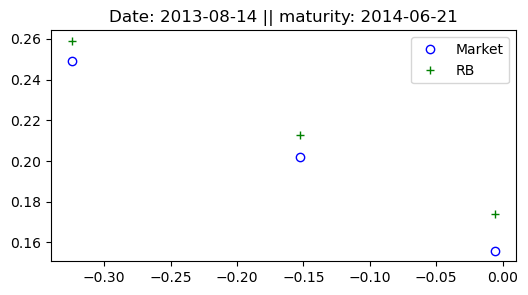

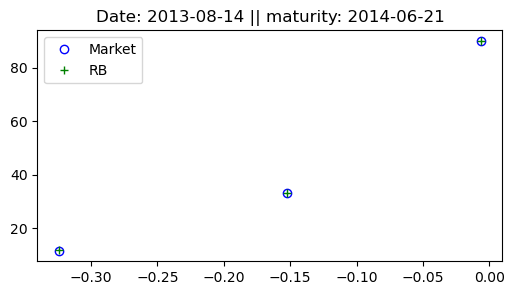

0.00016589042121497308


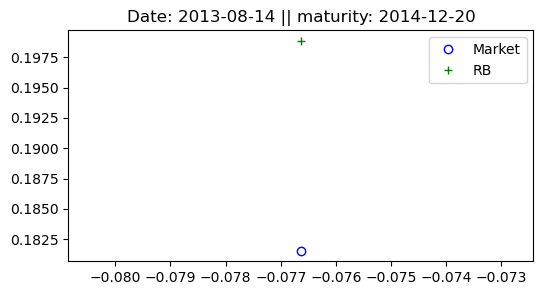

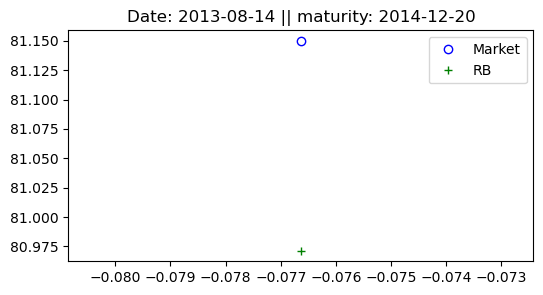

0.0002999898677227275


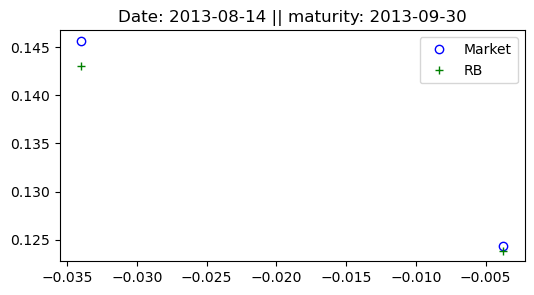

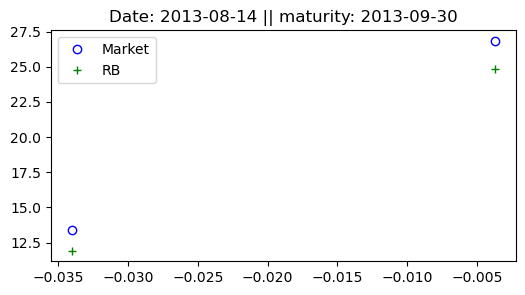

2.4071243159603808e-06


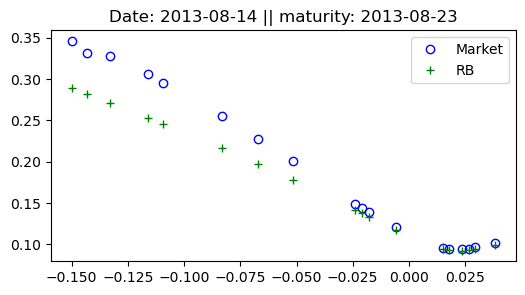

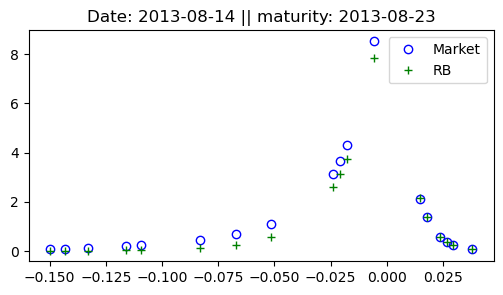

0.0004736006367484362


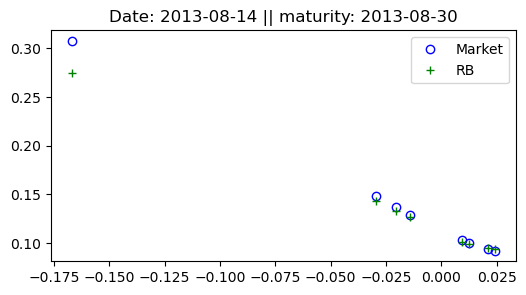

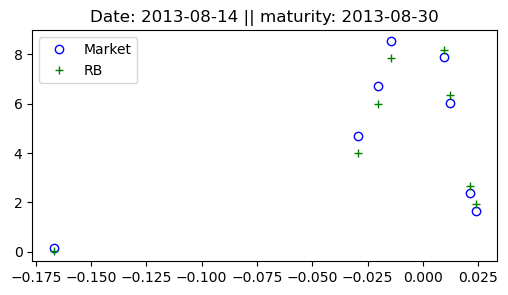

3.134415301858499e-05


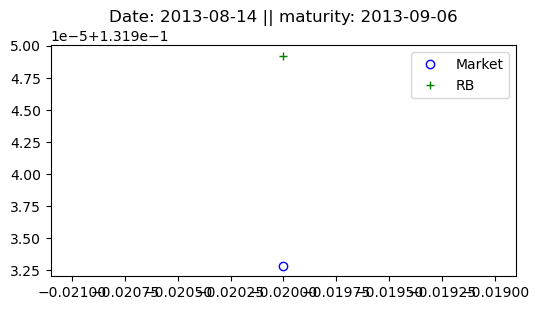

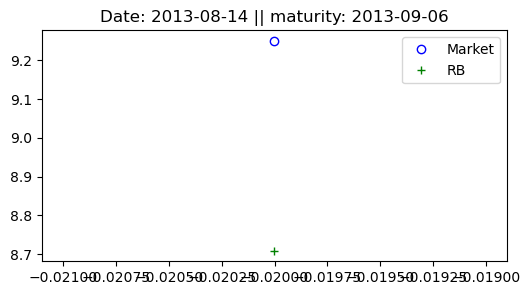

2.675038276184376e-10


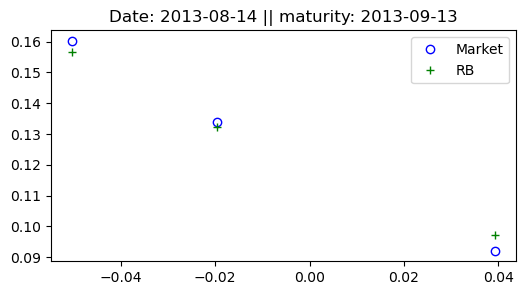

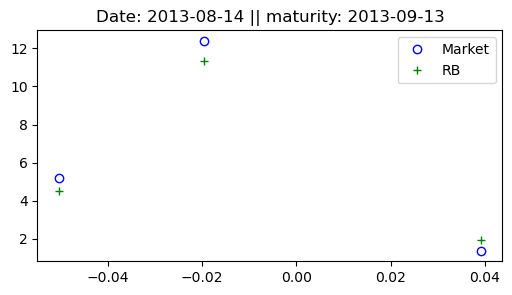

9.538863365440776e-11


In [51]:
## Carry out calibration with fixed Hurst parameter
RB.use_exact_sim = True
RB.eval_exact =True
maturities_list = list(range(len(dfDict[data.allDates[0]])))
RB.AMCC_calibrate(print_options = [True, True], plot_maturities=maturities_list)

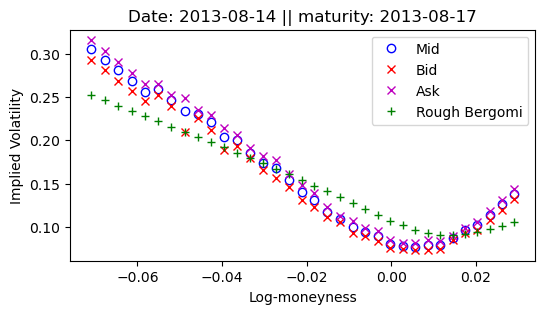

0.17647058823529413


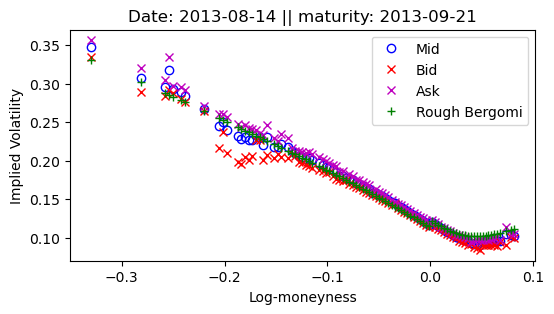

0.5806451612903226


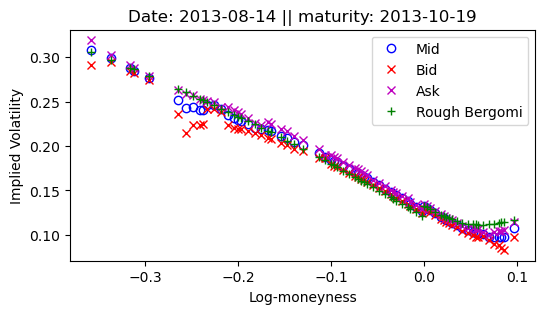

0.4507042253521127


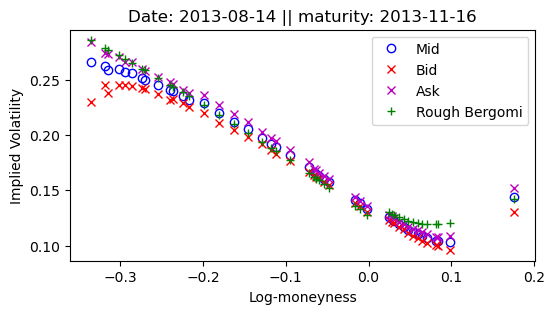

0.3409090909090909


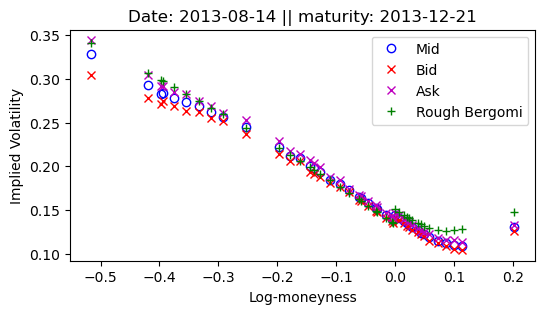

0.35714285714285715


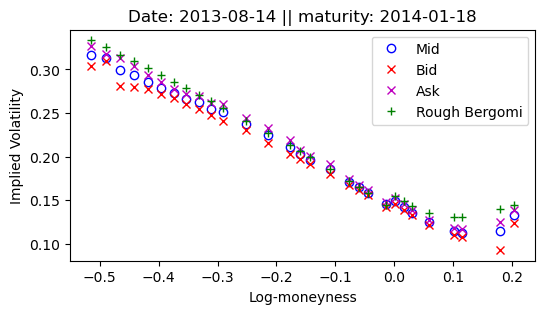

0.3793103448275862


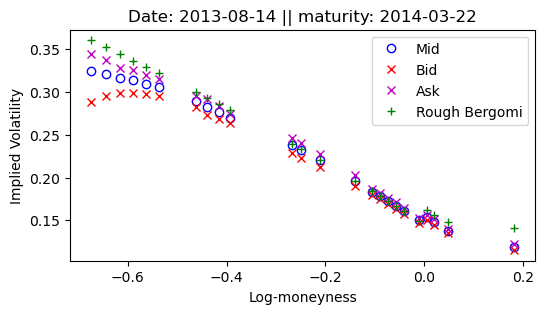

0.4166666666666667


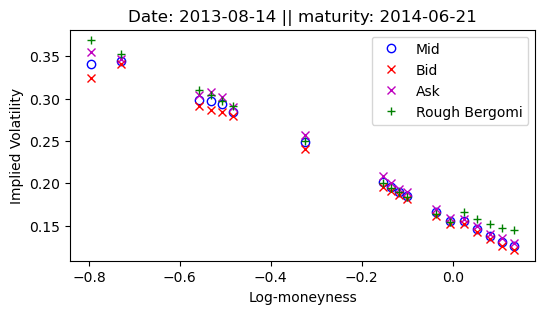

0.5


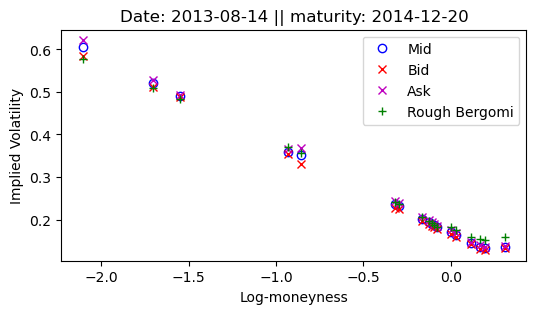

0.4444444444444444


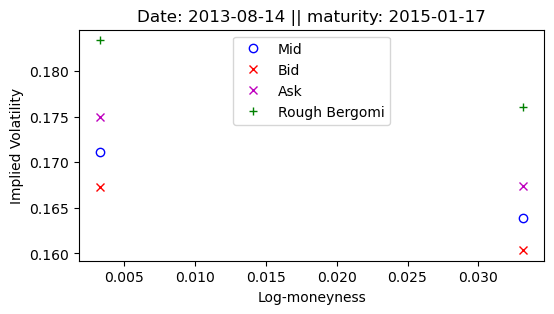

0.0


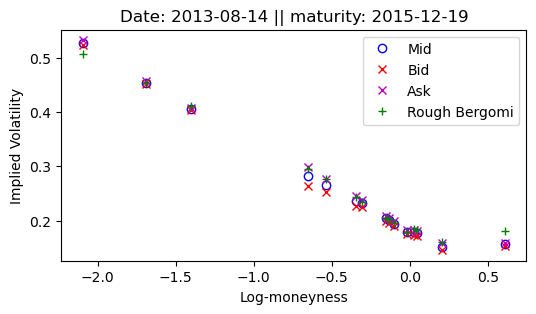

0.6


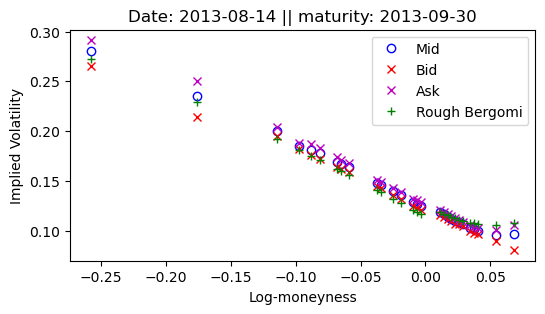

0.21428571428571427


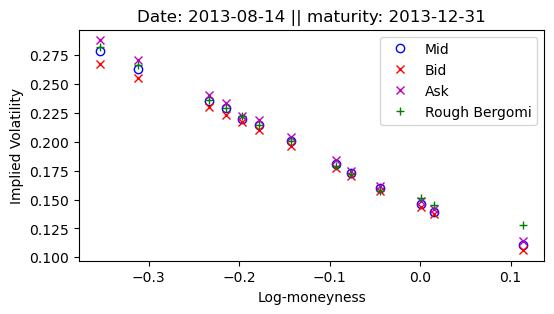

0.6923076923076923
Loss: 0.630534871509907
MAPE: 21.60736831917515
Hits: 0.42691415313225056
Delta_spread: 1.6741320993173958
Market metric: 1.0


In [52]:



loss,hits,delta = evaluate_RMSE(data_full,RB,show_plots=True)

In [35]:
### Set to true to evaluate using the initial parameters. 
if False:  
    RB.eta =  torch.tensor(2.3)
     
    RB.rho = torch.tensor(-0.9)
    RB.sqrt_rho = torch.sqrt(1-RB.rho**2)
    
    
    ## Evaluate performance on original parameters. 
    RB.use_exact_sim = True
    RB.eval_exact =True
    loss,hits,delta = evaluate_RMSE(data_full,RB,show_plots=False)



0.20588235294117646
0.010752688172043012
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Loss: 0.6861323561391212
MAPE: 25.54972344582624
Hits: 0.018561484918793503
Delta_spread: 8.113393757503488
Market metric: 0.9582366589327146


In [ ]:
### Calibrate also for subsequent dates, using the previous parameters as starting point.

loss_list = [loss]
hits_list = [hits]
delta_list = [delta]
for i in range(1,len(dates)):
    RB.select_date_ind = i
    RB.build_cholesky(RB.select_date_ind)
    maturities_list = list(range(len(dfDict[data.allDates[i]])))
    RB.AMCC_calibrate(print_options = [True, False], plot_maturities=maturities_list)
    loss,hits,delta = evaluate_RMSE(data_full,RB,show_plots=False)
    loss_list.append(loss)
    hits_list.append(hits)
    delta_list.append(delta)
print(loss_list)
print(hits_list)
print(delta_list)

In [ ]:
### Print and plot the MSE
plt.figure()
plt.plot(dates,loss_list,'gx')
tickslist=[dates[i] for i in range(0,len(dates),3)]
tickslist.append(dates[-1])
plt.xticks(tickslist)
plt.ylabel('Mean-squared error')
plt.savefig('MSE')
plt.show()

In [ ]:
import pandas as pd

results = np.array([loss_list,hits_list,delta_list])

df = pd.DataFrame(results.T)

df.columns=['Loss','Hits','Delta']

df.to_csv('Results1.csv')